In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.io.cif import CifWriter
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.core import Spin
from scipy.interpolate import UnivariateSpline
import pandas as pd

In [10]:
mp_key = "saKvn4nYOR6knw5q6WoAxtMKCsoAG1gq"
mp_id = "mp-561586"

In [11]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()
ph_plot = PhononBSPlotter(ph_bs)
data = ph_plot.bs_plot_data()
distances = data.get('distances')
frequences = data.get('frequency')

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

INTRODUCTION 

Dans un matériau cristallin, les vibrations atomiques peuvent être décrites par des phonons, qui représentent les quanta d'énergie associés aux ondes élastiques. L'analyse de la structure de bande des phonons permet d'extraire la vitesse du son dans différentes directions de la zone de Brillouin. l'objectif de ce travail est de calculer la vitesse du son pour trois branches acoustiques différentes dans trois directions différentes de la zone de Brillouin.

ZONE DE BRILLOUIN

In [12]:
plot_brillouin_zone(ph_bs.structure)


Voici à quoi ressemble la zone de Brillouin :


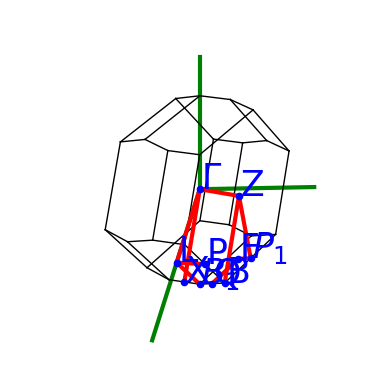

Visualisation de la structure de bande des phonons :


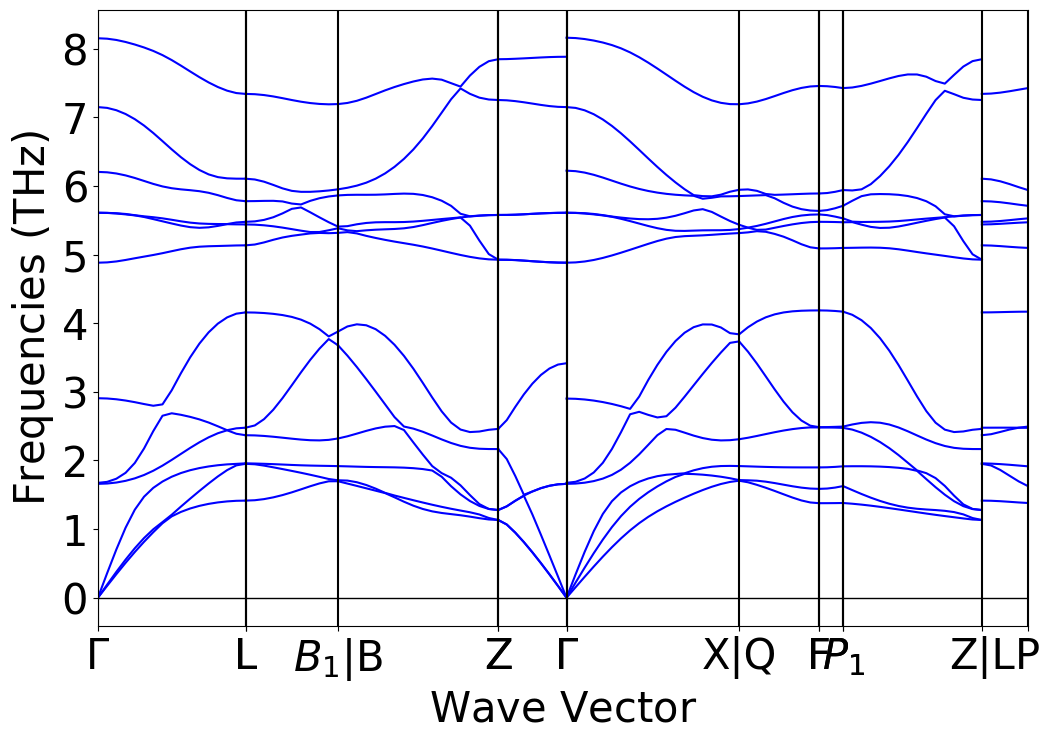

In [13]:

plot = PhononBSPlotter(ph_bs)
print("Voici à quoi ressemble la zone de Brillouin :")
plot.plot_brillouin()
print("Visualisation de la structure de bande des phonons :")
plot.show()

on remarque bien que le centre de la zone de brillouin correspond à  Γ

STRUCTURE BANDE DE PHONONS

In [14]:
fig_ph_bs = get_plot_bs(ph_bs)
fig_ph_bs.show()

CALCUL DES VITESSES DU SON

Calculer la vitesse du son pour trois branches acoustiques différentes dans trois directions différentes de la zone de Brillouin.

La vitesse du son dans un cristal est déterminée à partir de la dispersion phononique en calculant la pente des branches acoustiques près du point Gamma, selon la relation v = dω/dq. Ce calcul repose sur l’hypothèse que, pour de faibles vecteurs d’onde (q → 0), la relation de dispersion est linéaire. On distingue trois branches acoustiques : une longitudinale (LA) et deux transversales (TA1, TA2), dont la vitesse dépend des propriétés élastiques du matériau et de sa direction cristallographique. L’approximation numérique se fait en prenant le rapport des variations Δω / Δq sur les premiers points de la courbe de dispersion. Ce modèle suppose un milieu homogène et anisotrope, avec des interactions harmoniques dominantes entre les atomes.

Vitesse du son dans la direction Γ - X : 4056.22 m/s
Vitesse du son dans la direction K - Γ : 77.15 m/s
Vitesse du son dans la direction Γ - L : 2025.87 m/s


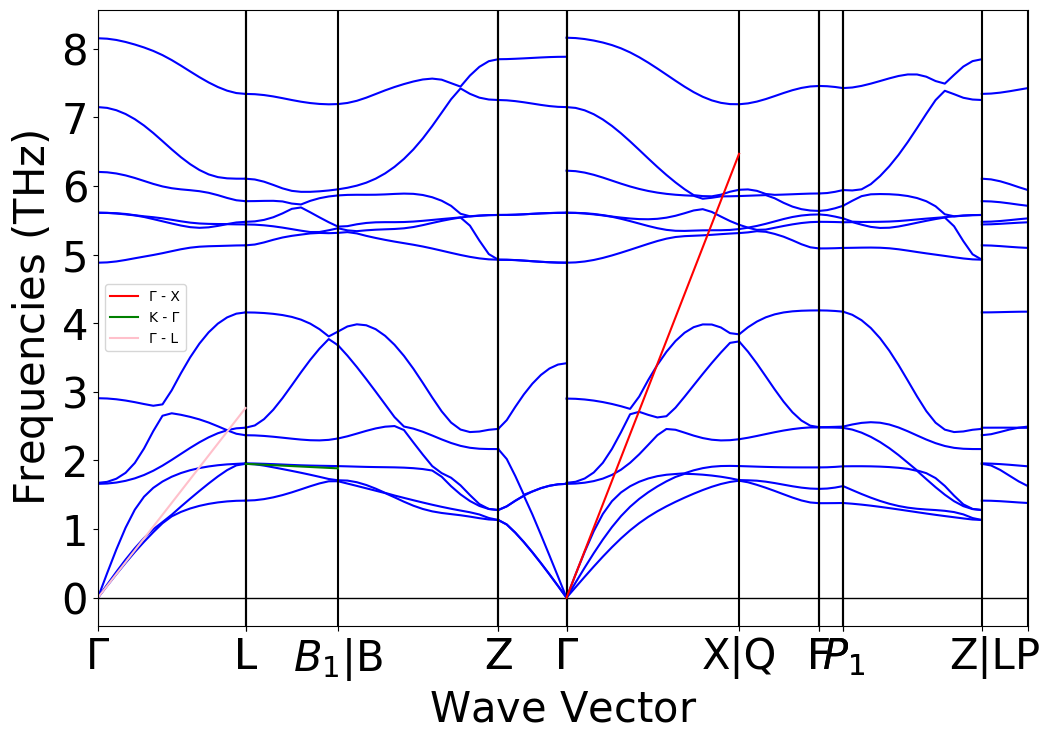

In [30]:
def compute_speed_of_sound(q_values, f_values):
    q_values = np.array(q_values) * 1e10  
    f_values = np.array(f_values) * 1e12  
    dq = q_values[1] - q_values[0]
    dw = 2 * np.pi * (f_values[1] - f_values[0])  
    return np.abs(dw / dq)  


q1, f1 = distances[4], frequences[4][2]  # Γ - X
q2, f2 = distances[1], frequences[1][1]  # K - Γ
q3, f3 = distances[0], frequences[0][0]  # Γ - L


v_s1 = compute_speed_of_sound(q1, f1)
v_s2 = compute_speed_of_sound(q2, f2)
v_s3 = compute_speed_of_sound(q3, f3)


print(f"Vitesse du son dans la direction Γ - X : {v_s1:.2f} m/s")
print(f"Vitesse du son dans la direction K - Γ : {v_s2:.2f} m/s")
print(f"Vitesse du son dans la direction Γ - L : {v_s3:.2f} m/s")


def line_through_first_point(x_vals, slope, f0):
    x = np.linspace(x_vals[0], x_vals[-1], 1000)
    y = f0 + slope * (x - x_vals[0])
    return x, y


a1 = (f1[1] - f1[0]) / (q1[1] - q1[0])
a2 = (f2[1] - f2[0]) / (q2[1] - q2[0])
a3 = (f3[1] - f3[0]) / (q3[1] - q3[0])


x1, y1 = line_through_first_point(q1, a1, f1[0])
x2, y2 = line_through_first_point(q2, a2, f2[0])
x3, y3 = line_through_first_point(q3, a3, f3[0])

bsplotter.get_plot()
plt.plot(x1, y1, color='red', label='Γ - X')
plt.plot(x2, y2, color='green', label='K - Γ')
plt.plot(x3, y3, color='pink', label='Γ - L')
plt.legend()
plt.show()
